In [1]:
from deepcrypto.backtest import *
from deepcrypto.portfolio_analysis import *
from deepcrypto.data_utils.crawlers.bitfinex_kaggle import *
from deepcrypto.data_utils.crawlers.binance_crawler import *
from talib.abstract import *
from pprint import pprint

In [2]:
def strategy(df, config):
    ibsperiod = config["ibsperiod"]
    
    lowestlow = df.low.rolling(ibsperiod).min()
    highesthigh = df.high.rolling(ibsperiod).max()
    
    ibs = (df.close - lowestlow) / (highesthigh - lowestlow) * 100
    
    ibs_signal = ibs > config["ibsthres"]
    volume_signal = df.volume / df.volume.rolling(config["volumeperiod"]).mean()
    volume_signal = volume_signal > config["volumethres"]
    
    signal = volume_signal & ibs_signal
    
    df["enter_long"] = signal & (signal.diff() == 1)
    df["trade_cost"] = 0
    df["bet"] = np.clip(0.01 / df.close.pct_change().rolling(200).std(), 0.1, 2) * 2
    df["stop_loss"] = config["stop_loss"]
    df["take_profit"] = config["take_profit"]
    df["time_cut"] = config["time_cut"]
    return df

In [3]:
def backtest_and_report(config, ticker, db="binance"):
    if db=="bitfinex":
        data = read_bitfinex_data("/home/ych/Storage/bitfinex/bitfinex.db", "1H", ticker)
    else: data = read_binance_data("/home/ych/Storage/binance/binance.db", "1H", ticker)
    data = data.backtest.add_defaults()

    order, port = strategy(data, config).backtest()
    pprint(calc_from_order_df(order))
    qs.reports.full(port["portfolio_value"].resample("1D").last(), benchmark=port["open"].resample("1D").last())

backtest completed in 0.16615009307861328 seconds
{'bothside_avg_holding_bars': 10.381081081081081,
 'bothside_profit_factor': 1.192151255171867,
 'bothside_total_profit': 103507275.88732624,
 'bothside_total_trades': 370,
 'bothside_win_rate': 60.0,
 'buyside_avg_holding_bars': 10.381081081081081,
 'buyside_profit_factor': 1.192151255171867,
 'buyside_total_profit': 103507275.88732624,
 'buyside_total_trades': 370,
 'buyside_win_rate': 60.0,
 'sellside_avg_holding_bars': nan,
 'sellside_profit_factor': nan,
 'sellside_total_profit': 0.0,
 'sellside_total_trades': 0,
 'sellside_win_rate': nan}


/home/ych/PycharmProjects/DeepCrypto/deepcrypto/portfolio_analysis/__init__.py:7: RuntimeWarning: invalid value encountered in long_scalars
  a[f"{label}_win_rate"] = order_df.realized[order_df.realized >= 0].count()/order_df.realized.count() * 100


                           Strategy       Benchmark
-------------------------  -------------  -----------
Start Period               2016-03-18     2016-03-18
End Period                 2021-05-18     2021-05-18
Risk-Free Rate             0.0%           0.0%
Time in Market             26.0%          97.0%

Cumulative Return          1,035,072.76%  31,191.55%
CAGR%                      497.89%        203.87%

Sharpe                     2.35           1.31
Sortino                    6.14           2.07
Sortino/√2                 4.34           1.46

Max Drawdown               -28.9%         -93.85%
Longest DD Days            146            1101
Volatility (ann.)          59.62%         87.76%
R^2                        0.11           0.11
Calmar                     17.23          2.17
Skew                       4.06           0.38
Kurtosis                   29.17          5.56

Expected Daily %           0.49%          0.3%
Expected Monthly %         15.81%         9.55%
Expected Yearly 

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-09-17,2020-11-02,2021-01-06,111,-28.904023,-28.689243
2,2018-08-18,2018-11-11,2018-12-23,127,-17.886347,-16.173762
3,2020-01-08,2020-01-12,2020-01-14,6,-16.118678,-14.245899
4,2019-02-27,2019-03-15,2019-03-16,17,-16.092306,-12.465893
5,2021-04-09,2021-04-12,2021-05-03,24,-15.444556,-7.011955


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


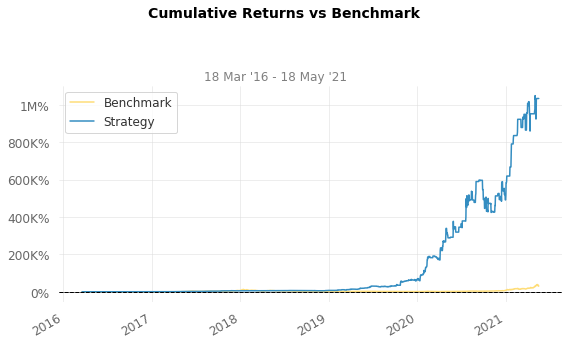

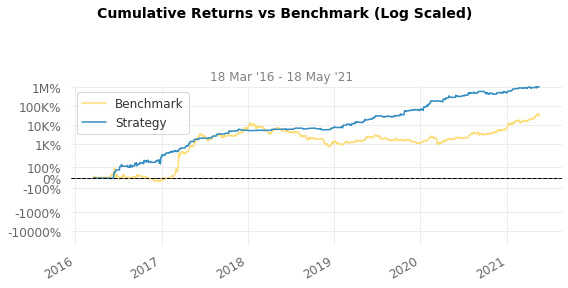

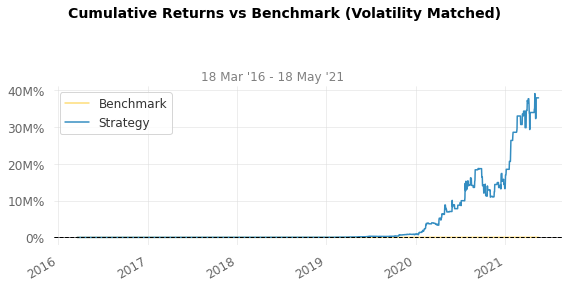

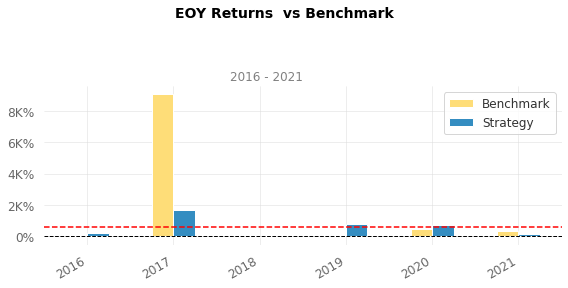

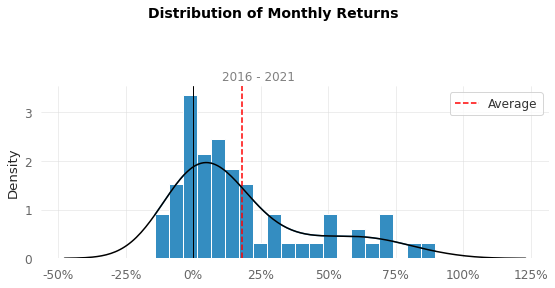

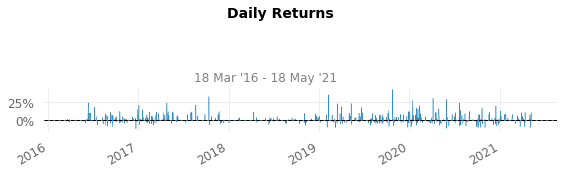

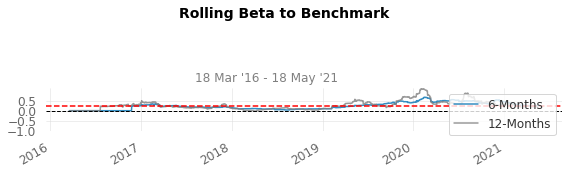

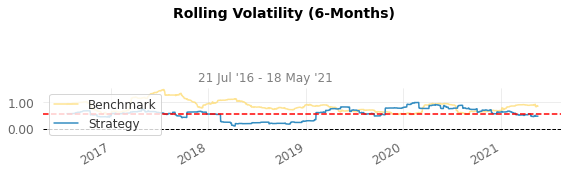

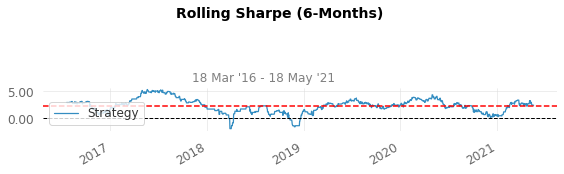

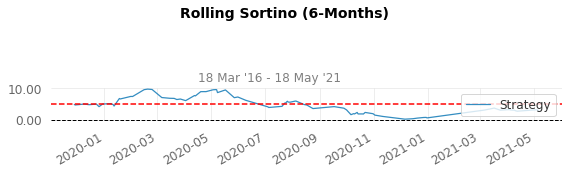

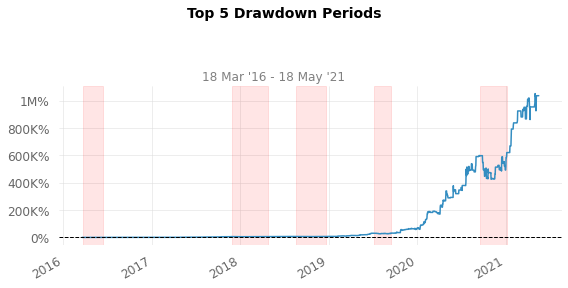

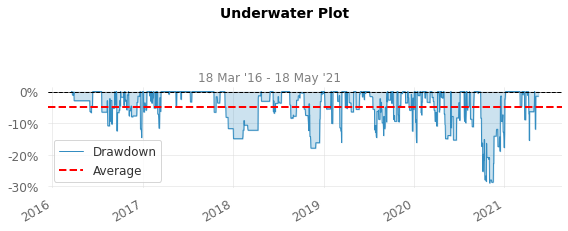

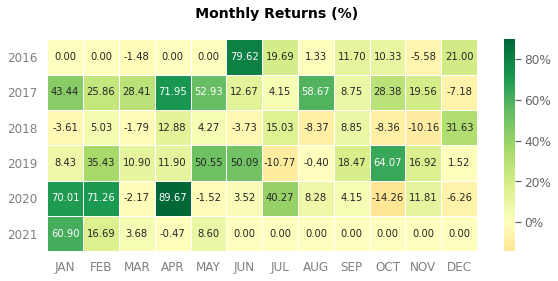

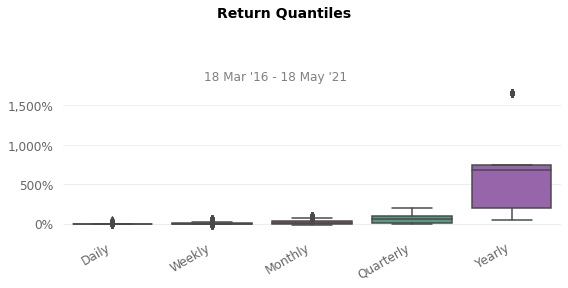

In [4]:
DEFAULT_CONFIG = {'time_cut': 12,
 'stop_loss': 0.03,
 'take_profit': 0.1,
 'ibsperiod': 24,
 'ibsthres': 70,
 'volumeperiod': 24,
 'volumethres': 4}

backtest_and_report(DEFAULT_CONFIG, "ETHUSD", "bitfinex")

backtest completed in 0.041214942932128906 seconds
{'bothside_avg_holding_bars': 10.476744186046512,
 'bothside_profit_factor': 1.7535474040336065,
 'bothside_total_profit': 171575.02939239418,
 'bothside_total_trades': 86,
 'bothside_win_rate': 63.95348837209303,
 'buyside_avg_holding_bars': 10.476744186046512,
 'buyside_profit_factor': 1.7535474040336065,
 'buyside_total_profit': 171575.02939239418,
 'buyside_total_trades': 86,
 'buyside_win_rate': 63.95348837209303,
 'sellside_avg_holding_bars': nan,
 'sellside_profit_factor': nan,
 'sellside_total_profit': 0.0,
 'sellside_total_trades': 0,
 'sellside_win_rate': nan}


/home/ych/PycharmProjects/DeepCrypto/deepcrypto/portfolio_analysis/__init__.py:7: RuntimeWarning: invalid value encountered in long_scalars
  a[f"{label}_win_rate"] = order_df.realized[order_df.realized >= 0].count()/order_df.realized.count() * 100


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2017-08-25  2017-08-25
End Period                 2021-05-09  2021-05-09
Risk-Free Rate             0.0%        0.0%
Time in Market             9.0%        100.0%

Cumulative Return          1,721.90%   1,085.61%
CAGR%                      118.8%      94.86%

Sharpe                     1.56        0.98
Sortino                    4.47        1.44
Sortino/√2                 3.16        1.02

Max Drawdown               -19.73%     -93.98%
Longest DD Days            191         1101
Volatility (ann.)          38.96%      80.74%
R^2                        0.05        0.05
Calmar                     6.02        1.01
Skew                       7.78        -0.15
Kurtosis                   100.01      4.05

Expected Daily %           0.21%       0.18%
Expected Monthly %         6.51%       5.52%
Expected Yearly %          78.69%      63.98%
Kelly Criterion            34

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-06-15,2018-11-01,2018-12-23,191,-19.733661,-19.008015
2,2019-11-10,2019-12-30,2020-01-14,65,-17.932541,-17.442073
3,2019-03-06,2019-04-07,2019-05-07,62,-16.231024,-16.213240
4,2020-03-20,2020-04-02,2020-04-06,17,-11.463600,-4.219939
5,2020-10-06,2020-10-06,2020-12-17,72,-10.916179,-9.233498


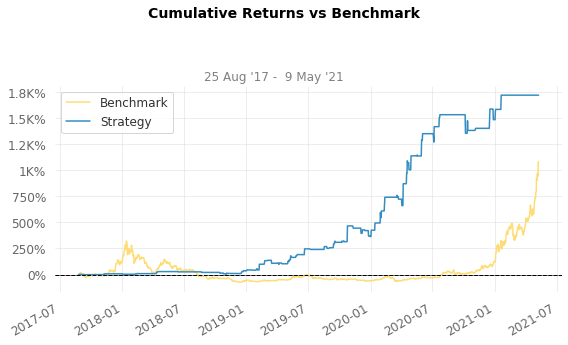

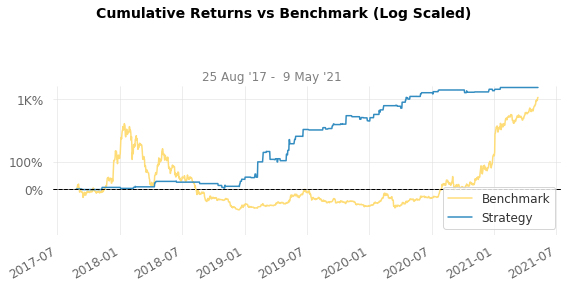

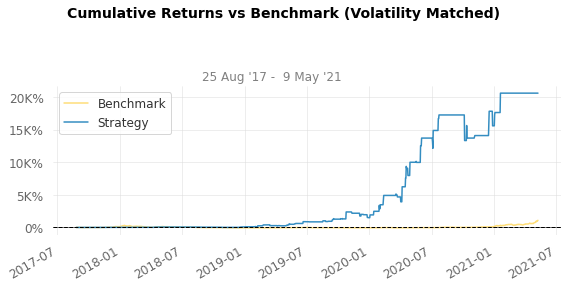

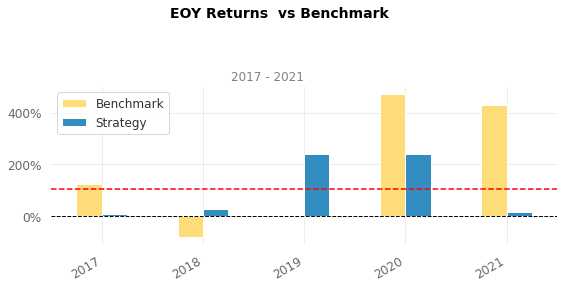

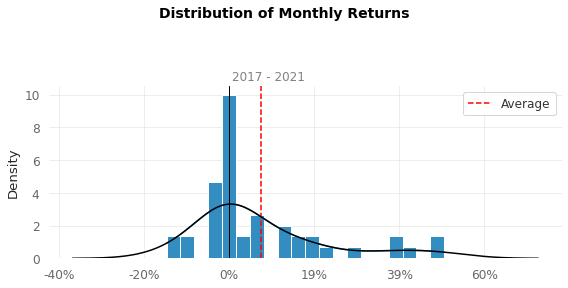

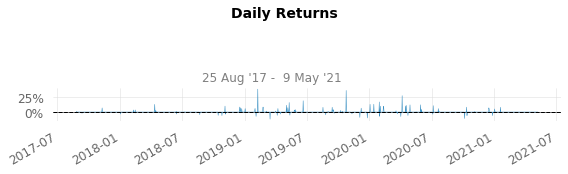

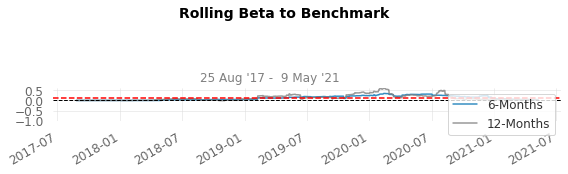

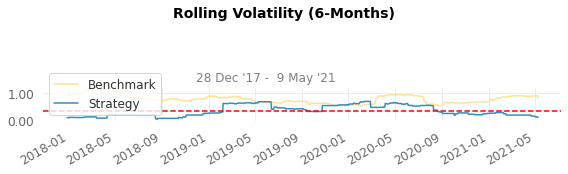

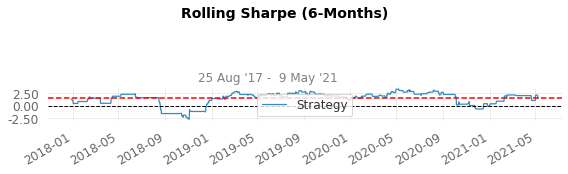

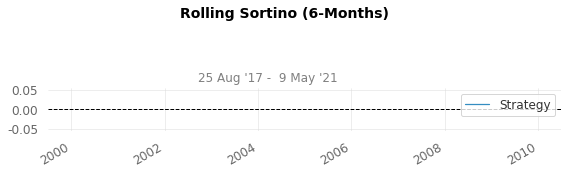

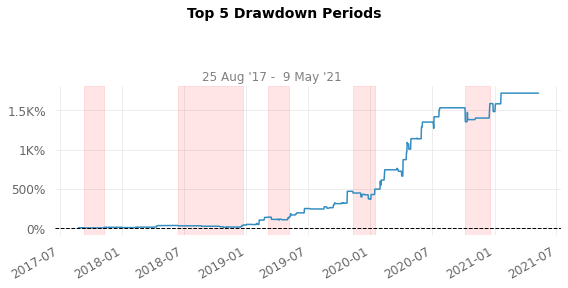

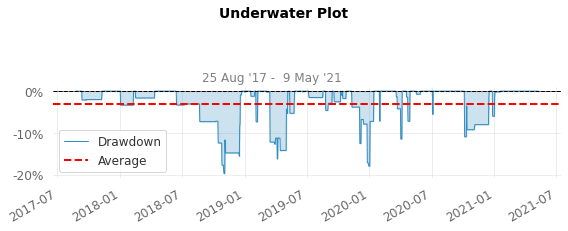

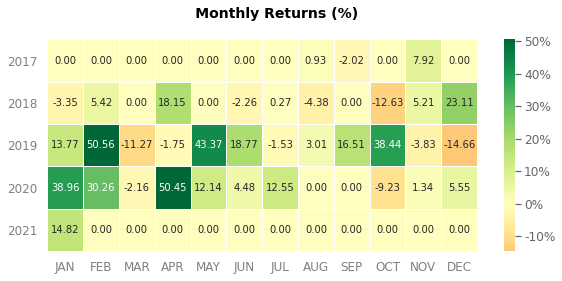

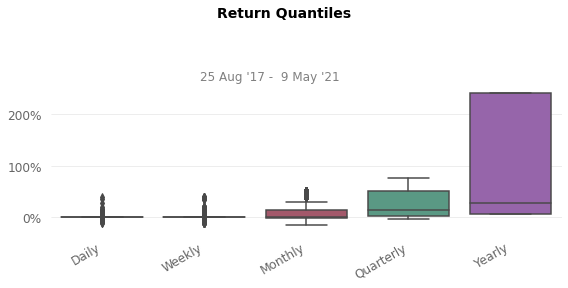

In [5]:
backtest_and_report(DEFAULT_CONFIG, "ETHUSDT", "binance")

backtest completed in 0.08988618850708008 seconds
{'bothside_avg_holding_bars': 18.869646182495345,
 'bothside_profit_factor': 1.2751240000768924,
 'bothside_total_profit': 2777920169.757169,
 'bothside_total_trades': 537,
 'bothside_win_rate': 53.81750465549349,
 'buyside_avg_holding_bars': 18.869646182495345,
 'buyside_profit_factor': 1.2751240000768924,
 'buyside_total_profit': 2777920169.757169,
 'buyside_total_trades': 537,
 'buyside_win_rate': 53.81750465549349,
 'sellside_avg_holding_bars': nan,
 'sellside_profit_factor': nan,
 'sellside_total_profit': 0.0,
 'sellside_total_trades': 0,
 'sellside_win_rate': nan}


/home/ych/PycharmProjects/DeepCrypto/deepcrypto/portfolio_analysis/__init__.py:7: RuntimeWarning: invalid value encountered in long_scalars
  a[f"{label}_win_rate"] = order_df.realized[order_df.realized >= 0].count()/order_df.realized.count() * 100


                           Strategy        Benchmark
-------------------------  --------------  -----------
Start Period               2013-04-09      2013-04-09
End Period                 2021-05-18      2021-05-18
Risk-Free Rate             0.0%            0.0%
Time in Market             30.0%           96.0%

Cumulative Return          27,779,201.70%  18,597.53%
CAGR%                      368.86%         90.56%

Sharpe                     2.02            0.99
Sortino                    5.32            1.48
Sortino/√2                 3.76            1.04

Max Drawdown               -30.71%         -84.25%
Longest DD Days            184             1126
Volatility (ann.)          61.3%           69.36%
R^2                        0.1             0.1
Calmar                     12.01           1.07
Skew                       5.38            0.14
Kurtosis                   55.26           10.5

Expected Daily %           0.42%           0.18%
Expected Monthly %         13.64%          5.4

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-05-17,2020-07-22,2020-11-17,184,-30.709124,-29.668492
2,2019-08-06,2019-10-21,2019-11-27,113,-28.454738,-27.592633
3,2020-02-19,2020-04-02,2020-04-29,70,-27.420761,-24.038426
4,2014-03-09,2014-05-11,2014-05-22,74,-27.055297,-25.433348
5,2013-04-27,2013-06-20,2013-07-31,95,-24.196672,-20.894140


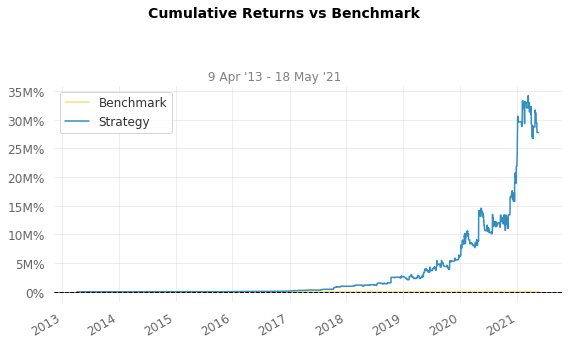

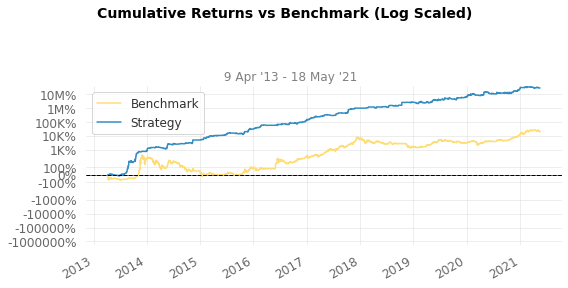

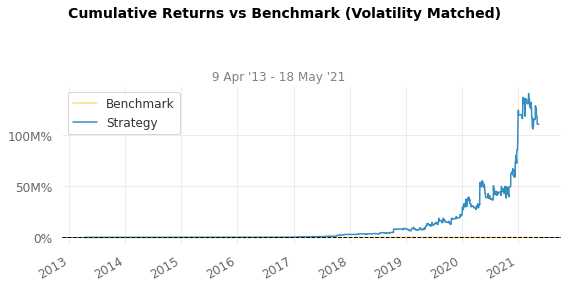

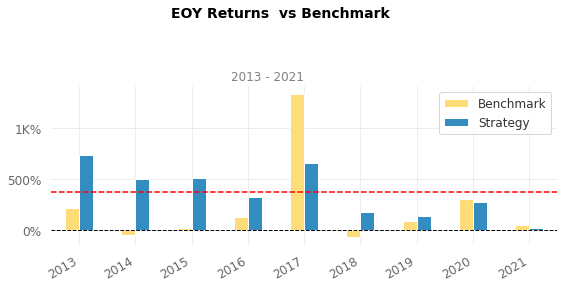

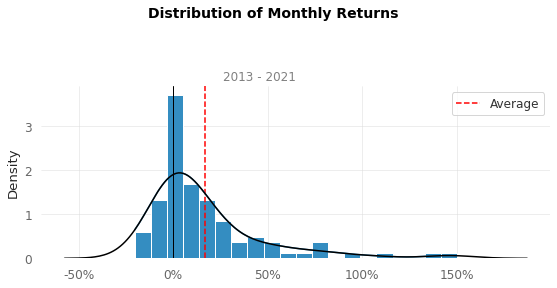

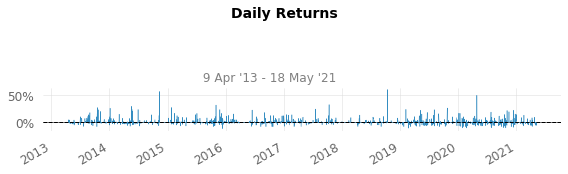

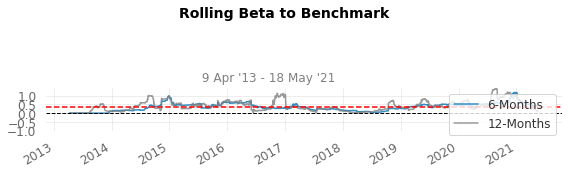

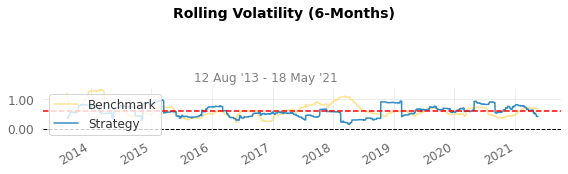

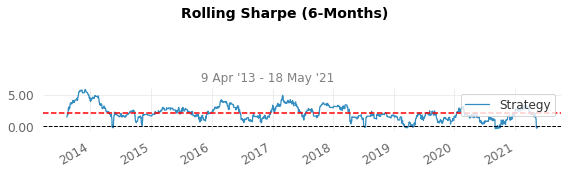

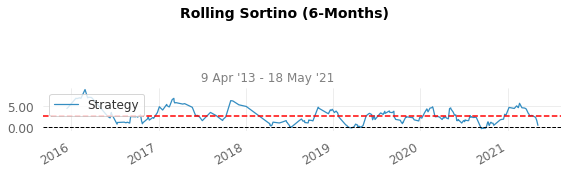

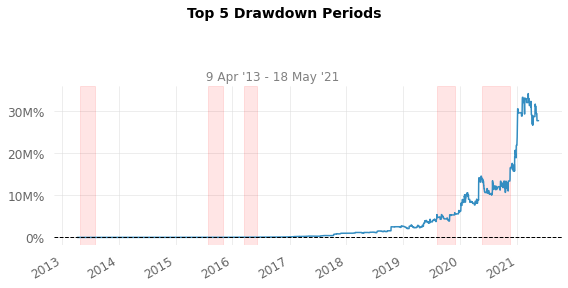

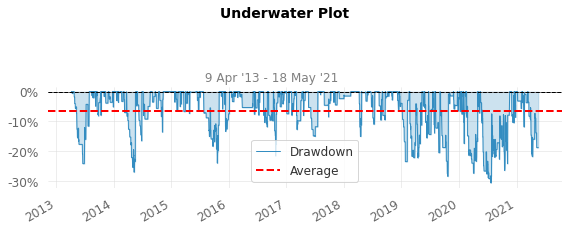

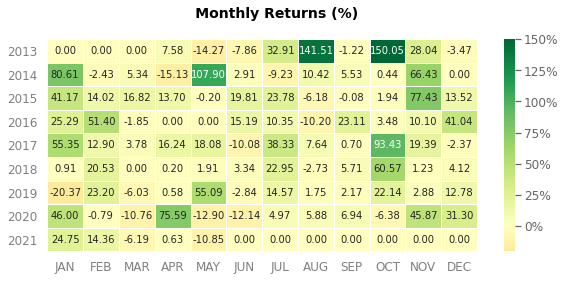

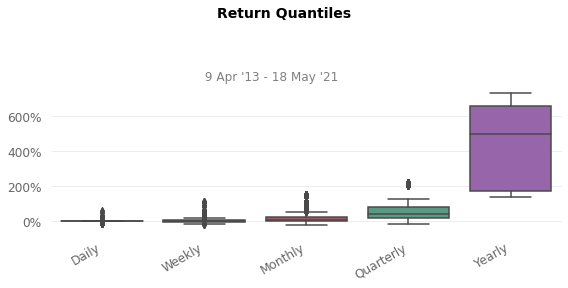

In [6]:
DEFAULT_CONFIG = {'time_cut': 24,
 'stop_loss': 0.02,
 'take_profit': 0.15,
 'ibsperiod': 48,
 'ibsthres': 70,
 'volumeperiod': 24,
 'volumethres': 4}

backtest_and_report(DEFAULT_CONFIG, "BTCUSD", "bitfinex")

backtest completed in 0.04024219512939453 seconds
{'bothside_avg_holding_bars': 17.05263157894737,
 'bothside_profit_factor': 2.3732342395738972,
 'bothside_total_profit': 56235.11522736679,
 'bothside_total_trades': 76,
 'bothside_win_rate': 47.368421052631575,
 'buyside_avg_holding_bars': 17.05263157894737,
 'buyside_profit_factor': 2.3732342395738972,
 'buyside_total_profit': 56235.11522736679,
 'buyside_total_trades': 76,
 'buyside_win_rate': 47.368421052631575,
 'sellside_avg_holding_bars': nan,
 'sellside_profit_factor': nan,
 'sellside_total_profit': 0.0,
 'sellside_total_trades': 0,
 'sellside_win_rate': nan}


/home/ych/PycharmProjects/DeepCrypto/deepcrypto/portfolio_analysis/__init__.py:7: RuntimeWarning: invalid value encountered in long_scalars
  a[f"{label}_win_rate"] = order_df.realized[order_df.realized >= 0].count()/order_df.realized.count() * 100


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2017-08-25  2017-08-25
End Period                 2021-05-09  2021-05-09
Risk-Free Rate             0.0%        0.0%
Time in Market             10.0%       100.0%

Cumulative Return          562.35%     1,267.92%
CAGR%                      66.54%      102.52%

Sharpe                     1.1         1.07
Sortino                    2.59        1.6
Sortino/√2                 1.83        1.13

Max Drawdown               -27.43%     -83.38%
Longest DD Days            479         1079
Volatility (ann.)          37.86%      65.55%
R^2                        0.05        0.05
Calmar                     2.43        1.23
Skew                       6.76        -0.07
Kurtosis                   82.75       4.36

Expected Daily %           0.14%       0.19%
Expected Monthly %         4.2%        5.85%
Expected Yearly %          45.95%      68.74%
Kelly Criterion            26

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-01-06,2019-08-26,2020-04-29,479,-27.428289,-25.665272
2,2021-02-16,2021-04-10,2021-05-09,82,-11.196684,-3.571564
3,2020-11-01,2020-11-30,2020-12-16,45,-7.993713,-3.742740
4,2020-08-18,2020-08-18,2020-10-09,52,-6.606529,-1.071841
5,2018-08-22,2018-09-19,2018-10-16,55,-6.471719,-4.979412


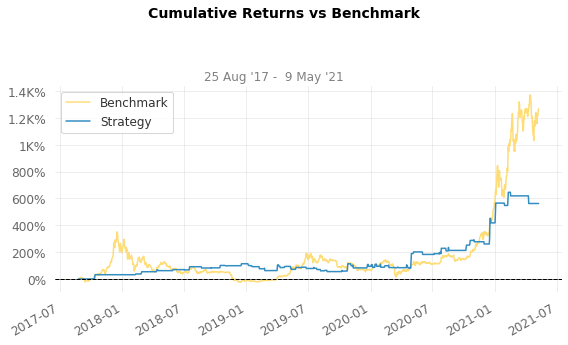

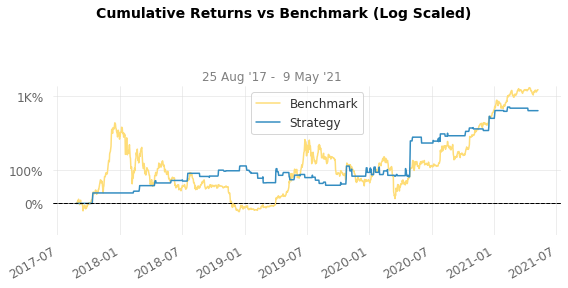

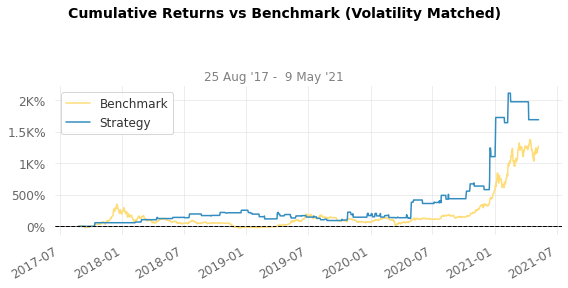

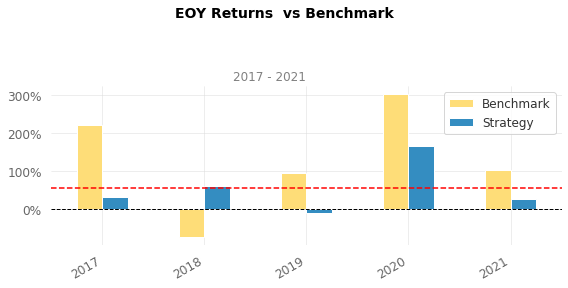

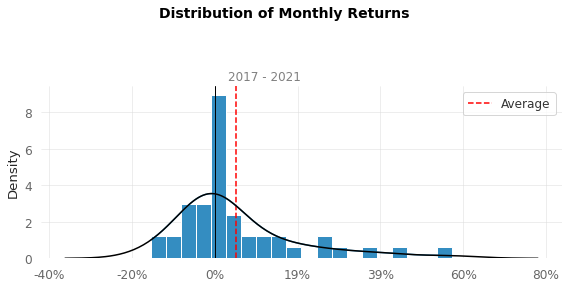

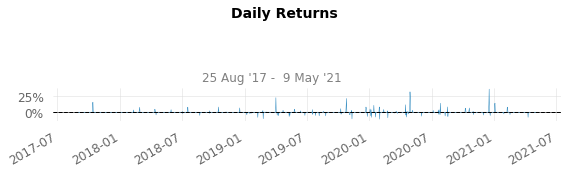

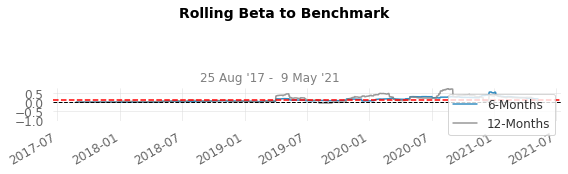

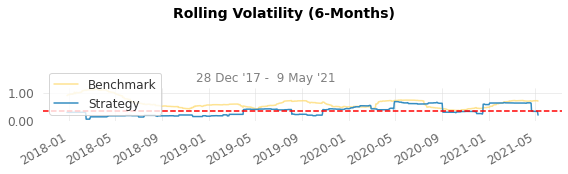

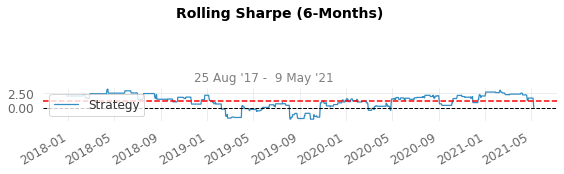

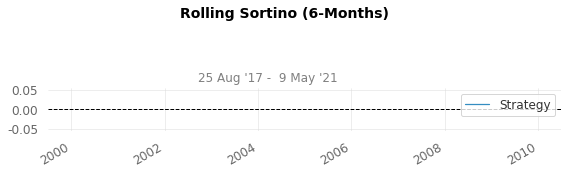

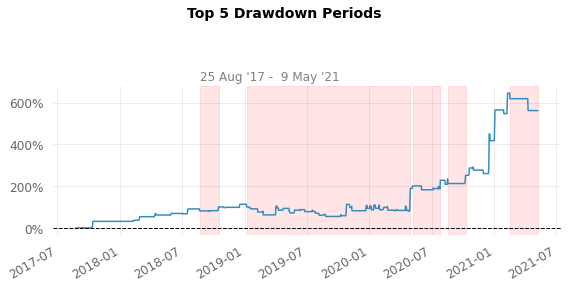

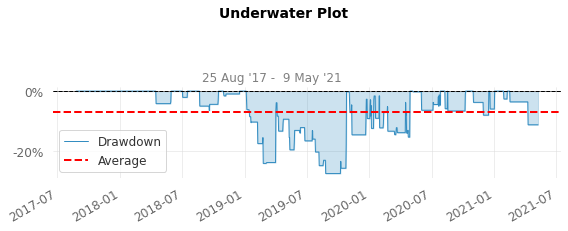

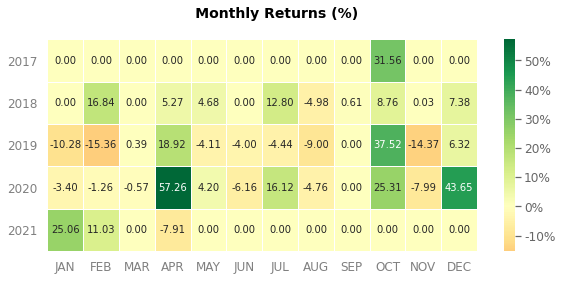

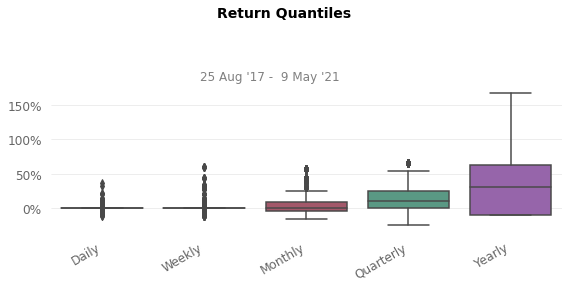

In [7]:
backtest_and_report(DEFAULT_CONFIG, "BTCUSDT", "binance")

In [8]:
import ray
from ray import tune
def optimizer(config, df):
    df = df.copy()
    order_df, port_df = run_backtest_df(strategy(df, config))
    tune.report(sortino=qs.stats.sortino(port_df["portfolio_value"].resample("1D").last()))

def optimize(df):
    result = tune.run(
        tune.with_parameters(optimizer, df=df),
        config = {
            "time_cut" : tune.grid_search([12, 24, 48]),
            "stop_loss" : tune.grid_search([0.02, 0.03, 0.05]),
            "take_profit" : tune.grid_search([0.05, 0.1, 0.15, 0.2]),
            'ibsperiod' : tune.grid_search([12, 24, 48]),
            'ibsthres' : tune.grid_search([70, 80, 90]),
            'volumeperiod' : tune.grid_search([6, 12, 24]),
            'volumethres' : tune.grid_search([3, 4, 5]),
        },
        local_dir="./ray_results",
    )
    return result

/home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


In [9]:
ray.init()

2021-05-28 00:50:46,788	INFO services.py:1269 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.68.106',
 'raylet_ip_address': '192.168.68.106',
 'redis_address': '192.168.68.106:6379',
 'object_store_address': '/tmp/ray/session_2021-05-28_00-50-45_816813_518742/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-05-28_00-50-45_816813_518742/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-05-28_00-50-45_816813_518742',
 'metrics_export_port': 39230,
 'node_id': '83157cfa49188206c49a4b3ce5efb6ea43fd70f0d2792d453f04cabe'}

In [10]:
data = read_binance_data("/home/ych/Storage/binance/binance.db", "1H", "BTCUSD")
data = data.backtest.add_defaults()

OperationalError: no such table: BTCUSD_1H

In [ ]:
data = data[:int(data.index.__len__() * 0.7)]

In [ ]:
result = optimize(data)

In [ ]:
result.get_best_config("sortino", mode="max")